# Tutorial Hands-on 2: Clasificación kNN (k-Nearest Neighbors)

**Nombre:** Christopher Leonardo Lopez Vilchis.

Este notebook sirve como tutorial completo sobre la técnica de clasificación kNN, implementándola en Python con `scikit-learn`.

## 1.1. Fundamentos de la técnica

El algoritmo **k-Nearest Neighbors (kNN)** o "k-Vecinos Más Cercanos" es uno de los algoritmos más simples e intuitivos de *machine learning*.

Imagina que eres nuevo en un vecindario y no sabes si identificarte como "amigable" o "reservado". ¿Qué haces? Miras a tus **'k' vecinos más cercanos**. Si de tus 3 (k=3) vecinos más cercanos, 2 son "amigables" y 1 es "reservado", probablemente tú también seas "amigable".

kNN hace exactamente eso:

1.  **Almacena** todos los datos de entrenamiento (por eso se le llama "lazy learner" o "aprendiz perezoso", ¡no "estudia" hasta que se lo pides!).
2.  Cuando recibe un **nuevo dato** para clasificar, mide la distancia de este nuevo punto a **todos** los puntos de entrenamiento.
3.  Selecciona los **'k' puntos más cercanos** (los 'k' vecinos con la distancia más corta).
4.  Realiza una **votación de mayoría**: la clase que más se repite entre esos 'k' vecinos es la clase que se le asigna al nuevo dato.

## 1.2. Modelo Matemático

El "modelo" de kNN no es una fórmula compleja como en la regresión lineal, sino que se basa en **medir la distancia**. La clave es cómo definimos "cercano".

La métrica de distancia más común es la **Distancia Euclidiana** (básicamente, el Teorema de Pitágoras para múltiples dimensiones).

Si tenemos dos puntos, $p$ y $q$, en un espacio de $n$ dimensiones (con $n$ características), la distancia se calcula como:

$$d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + \dots + (p_n - q_n)^2} = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}$$

Donde:
* $p_i$ es el valor de la característica $i$ para el punto $p$.
* $q_i$ es el valor de la característica $i$ para el punto $q$.

Otras distancias populares incluyen la **Distancia de Manhattan** (sumar las diferencias absolutas, como moverse en una cuadrícula) o la **Distancia de Minkowski** (que generaliza las dos anteriores).

## 1.3. Descripción de la librería

Para este tutorial, usaremos la librería por excelencia de Machine Learning en Python: **`scikit-learn`** (o `sklearn`).

Las funciones y clases clave que usaremos son:

* **`sklearn.datasets.load_iris`**: Para cargar un dataset de ejemplo clásico (Iris).
* **`sklearn.model_selection.train_test_split`**: Para dividir nuestros datos en un conjunto de entrenamiento (para que el modelo "memorice") y un conjunto de prueba (para ver qué tan bien lo hace).
* **`sklearn.preprocessing.StandardScaler`**: ¡Muy importante! Como kNN se basa en distancias, si una característica tiene una escala mucho mayor (ej. salario en miles vs. edad en decenas), dominará el cálculo. El *Scaler* pone todas las características en la misma escala.
* **`sklearn.neighbors.KNeighborsClassifier`**: Esta es la clase que implementa el modelo kNN. Le diremos cuántos vecinos (`n_neighbors=k`) usar.
* **`sklearn.metrics`**: Un módulo para evaluar el modelo. Usaremos:
    * **`confusion_matrix`**: Para ver exactamente dónde se equivocó el modelo.
    * **`accuracy_score`**: Para obtener el porcentaje de aciertos.

## 1.4. Pipeline

¡Aquí empieza el código! Primero, vamos a importar todas las librerías que necesitaremos.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings

### + Preprocesamiento

Vamos a cargar el dataset "Iris", que es perfecto para clasificación. Tiene 3 clases de flores (setosa, versicolor, virginica) y 4 características (largo y ancho del sépalo y pétalo).

In [4]:
# 1. Cargar los datos
iris = load_iris()
X = iris.data
y = iris.target

# 2. Convertir a DataFrame de Pandas para un análisis más fácil
df = pd.DataFrame(data=X, columns=iris.feature_names)
df['target'] = y
# Mapear el target a nombres de especies para los gráficos
df['species'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("Primeras 5 filas del dataset:")
print(df.head())

Primeras 5 filas del dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  


Ahora, realizamos el **análisis estadístico descriptivo** (avg, std, max, min) que nos pidieron.

In [5]:
# Análisis estadístico descriptivo
print("\n--- Análisis Estadístico Descriptivo ---")
# Usamos .loc para mostrar solo las métricas solicitadas
print(df.describe().loc[['mean', 'std', 'min', 'max']])


--- Análisis Estadístico Descriptivo ---
      sepal length (cm)  sepal width (cm)  petal length (cm)  \
mean           5.843333          3.057333           3.758000   
std            0.828066          0.435866           1.765298   
min            4.300000          2.000000           1.000000   
max            7.900000          4.400000           6.900000   

      petal width (cm)    target  
mean          1.199333  1.000000  
std           0.762238  0.819232  
min           0.100000  0.000000  
max           2.500000  2.000000  


Y ahora, el **Gráfico de Dispersión (Scatter Plot)**. Usaremos `seaborn` para visualizar la relación entre el largo y el ancho del pétalo, coloreando por especie. Esto nos ayuda a ver si las clases son "separables".

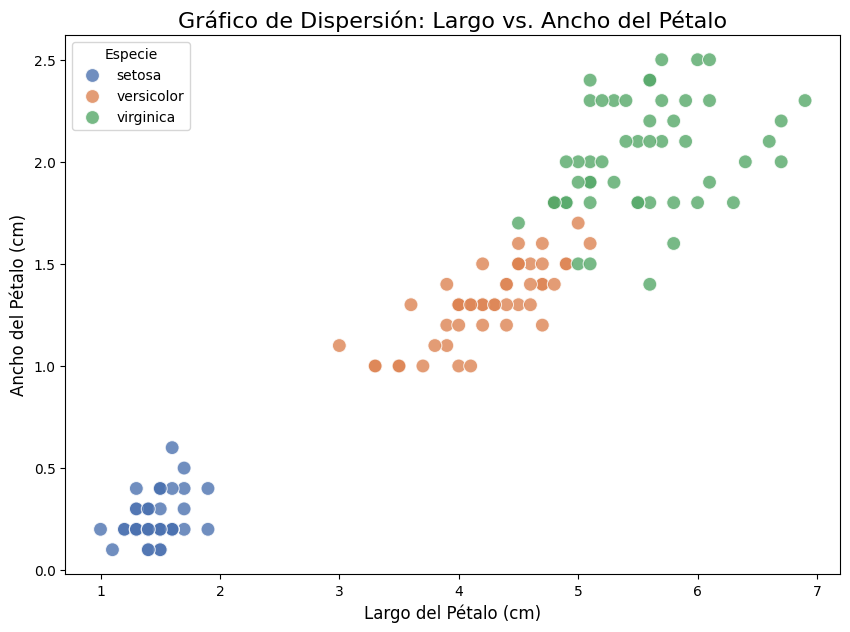

In [6]:
# Gráfico de Dispersión (Scatter Plot)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='petal length (cm)',
    y='petal width (cm)',
    hue='species',  # Colorear por la columna 'species'
    data=df,
    palette='deep',
    s=100,  # Tamaño de los puntos
    alpha=0.8
)
plt.title('Gráfico de Dispersión: Largo vs. Ancho del Pétalo', fontsize=16)
plt.xlabel('Largo del Pétalo (cm)', fontsize=12)
plt.ylabel('Ancho del Pétalo (cm)', fontsize=12)
plt.legend(title='Especie')
plt.show()

**Interpretación del gráfico:** Como podemos ver, la especie 'setosa' (azul) está muy bien separada del resto. 'Versicolor' (naranja) y 'virginica' (verde) están más mezcladas, pero kNN debería ser capaz de encontrar un buen límite.

### + Feature Engineering (Preparación de datos)

En la sección anterior (Preprocesamiento) ya identificamos nuestras características.

**Selección de variables:** Para este tutorial, usaremos las 4 características (`sepal length`, `sepal width`, `petal length`, `petal width`), ya que el gráfico sugiere que al menos las de pétalo son muy útiles.

El "Feature Engineering" aquí consiste en dos pasos cruciales:

1.  **División (Train/Test Split):** Separamos nuestros datos (70% para entrenar, 30% para probar).
2.  **Escalado:** Aplicamos `StandardScaler` para que todas las características tengan media 0 y desviación estándar 1. Esto es VITAL para kNN.

In [ ]:
# 1. Separar las características (X) y la etiqueta (y)
# Ya lo tenemos: X (features), y (target)

# 2. Dividir en Train y Test
# random_state=42 asegura que la división sea siempre la misma (reproducible)
# stratify=y asegura que la proporción de clases sea la misma en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaño del set de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del set de Prueba: {X_test.shape[0]} muestras")

# 3. Escalar los datos
scaler = StandardScaler()

# OJO: ¡Ajustamos (fit) el escalador SÓLO con los datos de train!
X_train_scaled = scaler.fit_transform(X_train)

# Luego, SÓLO transformamos los datos de test (y los datos nuevos)
X_test_scaled = scaler.transform(X_test)

print("\nDatos escalados (primeras 3 filas de train):")
print(X_train_scaled[:3])

Tamaño del set de Entrenamiento: 105 muestras
Tamaño del set de Prueba: 45 muestras

Datos escalados (primeras 3 filas de train):
[[-0.90045861 -1.22024754 -0.4419858  -0.13661044]
 [ 0.38036614 -1.87955796  0.40282929  0.38029394]
 [-0.90045861  1.63676428 -1.2868009  -1.17041921]]


### + Predicción

Primero, creamos y "entrenamos" nuestro modelo kNN. Elegiremos un valor de **k=5** (un valor impar común para evitar empates).

In [ ]:
# Inicializar el clasificador kNN
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

# "Entrenar" el modelo (en kNN, esto solo almacena los datos de X_train_scaled y y_train)
knn_model.fit(X_train_scaled, y_train)

print(f"¡Modelo kNN entrenado con k={k}!")

¡Modelo kNN entrenado con k=5!


Ahora, creamos la función que recibe un patrón (las 4 medidas de una flor) y nos devuelve la clase predicha, tal como se pidió.

In [ ]:
# Nombres de las especies para que la función sea más clara
species_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

def predecir_flor(patron):
    """
    Recibe un patrón (lista o array de 4 floats) y predice la especie de Iris.
    Ejemplo: [5.1, 3.5, 1.4, 0.2]
    """
    try:
        # 1. Asegurarnos que el patrón sea un array 2D para sklearn
        if isinstance(patron, list):
            patron_array = np.array(patron)
        else:
            patron_array = patron

        if patron_array.shape != (4,):
            print("Error: El patrón debe tener exactamente 4 características.")
            return

        patron_2d = patron_array.reshape(1, -1)

        # 2. ¡IMPORTANTE! Debemos escalar este nuevo patrón
        #    usando el MISMO escalador (scaler) que entrenamos.
        patron_scaled = scaler.transform(patron_2d)

        # 3. Hacer la predicción
        prediccion_numerica = knn_model.predict(patron_scaled)
        probabilidades = knn_model.predict_proba(patron_scaled)

        # 4. Obtener el nombre de la especie
        clase_predicha = prediccion_numerica[0]
        nombre_predicho = species_names[clase_predicha]
        confianza = np.max(probabilidades) * 100

        print(f"--- 🌺 Predicción de Flor 🌺 ---")
        print(f"Patrón de entrada: {patron}")
        print(f"Clase predicha:   {nombre_predicho} (Clase {clase_predicha})")
        print(f"Confianza:        {confianza:.2f}%")

        return nombre_predicho

    except Exception as e:
        print(f"Ocurrió un error: {e}")

# --- Probemos la función ---

# Ejemplo 1: Una flor con características de Setosa (valores bajos)
print("--- Prueba 1 ---")
flor_setosa = [5.1, 3.5, 1.4, 0.2]
predecir_flor(flor_setosa)

print("\n")

# Ejemplo 2: Una flor con características de Virginica (valores altos)
print("--- Prueba 2 ---")
flor_virginica = [6.7, 3.0, 5.2, 2.3]
prediccion_final = predecir_flor(flor_virginica)

--- Prueba 1 ---
--- 🌺 Predicción de Flor 🌺 ---
Patrón de entrada: [5.1, 3.5, 1.4, 0.2]
Clase predicha:   Setosa (Clase 0)
Confianza:        100.00%


--- Prueba 2 ---
--- 🌺 Predicción de Flor 🌺 ---
Patrón de entrada: [6.7, 3.0, 5.2, 2.3]
Clase predicha:   Virginica (Clase 2)
Confianza:        100.00%


### + Métricas

Nuestra función es útil, pero ¿qué tan bueno es el modelo *en general*? Para saberlo, usamos el conjunto de **Test** que habíamos guardado.

In [ ]:
# Usar el modelo entrenado para predecir sobre TODO el conjunto de test
y_pred = knn_model.predict(X_test_scaled)

# Ahora comparamos 'y_pred' (lo que dijo el modelo) con 'y_test' (la verdad)
print("Predicciones del modelo:", y_pred)
print("Valores reales:       ", y_test)

Predicciones del modelo: [2 1 1 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 1 1 1 1 1 0 1 2 1 0 2 0 0
 0 0 1 1 0 1 2 1]
Valores reales:        [2 1 2 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 1 1 1 1 0 2 2 1 0 2 0 0
 0 0 1 1 0 2 2 1]


#### Matriz de Confusión

La matriz de confusión nos dice exactamente dónde acertó y dónde se equivocó el modelo.

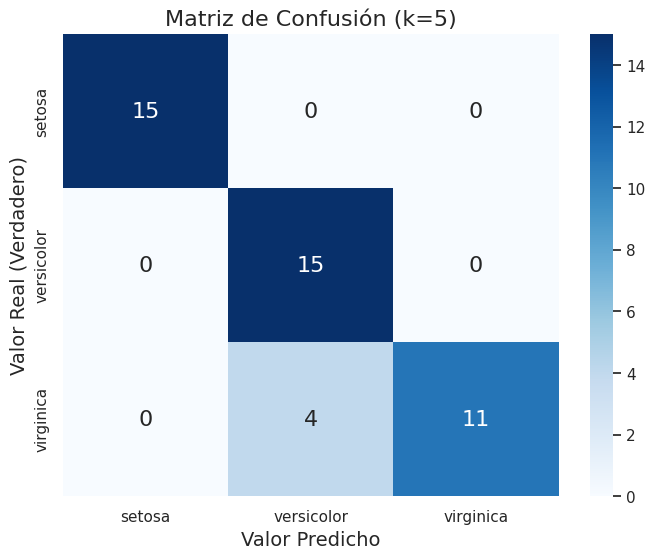

In [ ]:
# Calcular la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizarla con Seaborn para que sea más clara
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            annot_kws={"size": 16})
plt.xlabel('Valor Predicho', fontsize=14)
plt.ylabel('Valor Real (Verdadero)', fontsize=14)
plt.title('Matriz de Confusión (k=5)', fontsize=16)
plt.show()

**Breve explicación de los resultados:**

* **Fila "setosa"** (Real): Teniamos 15 flores setosa. El modelo predijo las 15 como setosa. (15 aciertos, 0 errores).

* **Fila "versicolor"** (Real): Teníamos 15 flores versicolor. El modelo predijo las 15 como versicolor. (15 aciertos, 0 errores).

* **Fila "virginica"** (Real): De 15 flores virginica. El modelo solo acertó 11, pero se equivocó con 4 y las clasificó como "versicolor".

#### Accuracy (Exactitud)

El *Accuracy* es la métrica más simple: es el porcentaje de predicciones correctas sobre el total.

(Aciertos / Total de Muestras)

In [ ]:
# Calcular el Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"--- Accuracy (Exactitud) ---")
print(f"El accuracy del modelo kNN (k=5) en el conjunto de prueba es: {acc:.4f}")
print(f"Esto significa que el {acc*100:.2f}% de las predicciones fueron correctas.")

# También podemos imprimir un reporte más completo
print("\n--- Reporte de Clasificación (Resumen) ---")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

--- Accuracy (Exactitud) ---
El accuracy del modelo kNN (k=5) en el conjunto de prueba es: 0.9111
Esto significa que el 91.11% de las predicciones fueron correctas.

--- Reporte de Clasificación (Resumen) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



**Explicación de los resultados:**

* **Accuracy (Exactitud)**: 0.9111 (o 91.11%) Esto es el "promedio general". Nos dice que el modelo acertó el 91.11% de las veces. (Como vimos, acertó 41 de 45 flores. 41/45 = 0.9111).

* El **Reporte de Clasificación**
* * **setosa**: Todo en 1.00. Perfecto.
* * **versicolor**: precision del 0.79. Significa que cuando el modelo dijo "versicolor", acertó el 79% de las veces. (¿Por qué? Porque a las 15 versicolor reales les sumó 4 virginica que predijo mal. 15 / (15+4) = 0.79).

recall (sensibilidad): 1.00. Significa que de todas las "versicolor" reales que había, el modelo las encontró todas (15 de 15).

* * **virginica:** precision de: 1.00. Significa que cuando el modelo dijo "virginica", acertó el 100% de las veces (no se equivocó y nunca llamó "virginica" a otra flor).

recall (sensibilidad): 0.73. Significa que de todas las "virginica" reales que había (eran 15), el modelo solo encontró 11. (11/15 = 0.73).

## 3. Referencias bibliográficas

1.  **Documentación Oficial de Scikit-learn:**
    * KNeighborsClassifier: [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    * Tutorial de kNN en Scikit-learn: [https://scikit-learn.org/stable/modules/neighbors.html](https://scikit-learn.org/stable/modules/neighbors.html)
2.  **Libro:**
    * James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An Introduction to Statistical Learning*. Springer, New York. (Capítulo 2.2.3, k-Nearest Neighbors).
3.  **Recurso web:**
    * Wikipedia (artículo sobre k-NN): [https://es.wikipedia.org/wiki/K-vecinos_m%C3%A1s_cercanos](https://es.wikipedia.org/wiki/K-vecinos_m%C3%A1s_cercanos)